In [5]:
!pip install SAS7BDAT
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
from sas7bdat import SAS7BDAT

In [6]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import make_pipeline
from sklearn import metrics

import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


In [8]:
import os
os.listdir("//duhsnas-pri/dusom_dhc/Private/KarraPrivate/Warfarin Dosing Project/COAG_2016a/Data/Analysis")

['redacted_coag_20141202_data1.sas7bdat',
 'redacted_coag_20141202_data2.sas7bdat',
 'redacted_coag_20141202_data3.sas7bdat',
 'redacted_coag_20141202_data4.sas7bdat',
 'redacted_coag_20141208_data5.sas7bdat',
 'redacted_coag_20141208_data6.sas7bdat',
 'redacted_coag_20141208_data7.sas7bdat']

In [10]:
from os import path

path.exists("//duhsnas-pri/dusom_dhc/Private/KarraPrivate/Warfarin Dosing Project/COAG_2016a/Data/Analysis/redacted_coag_20141202_data1.sas7bdat")

True

# Load DataFrames from COAG

In [27]:
# Dataset 1
data_path = '//duhsnas-pri/dusom_dhc/Private/KarraPrivate/Warfarin Dosing Project/COAG_2016a/Data/Analysis/redacted_coag_20141202_data1.sas7bdat'
#foo = SAS7BDAT(data_path)
#df1 = foo.to_data_frame()
df1 = pd.read_sas(data_path)

df1 = df1.dropna(subset=['maintain_dose'])
df1 = df1.reset_index(drop=True)

# Dataset 2
data_path = '//duhsnas-pri/dusom_dhc/Private/KarraPrivate/Warfarin Dosing Project/COAG_2016a/Data/Analysis/redacted_coag_20141202_data2.sas7bdat'
foo = SAS7BDAT(data_path)
df2 = foo.to_data_frame()
#df2 = pd.read_sas(data_path)

df2 = df2.dropna()

# Dataset 7
data_path = '//duhsnas-pri/dusom_dhc/Private/KarraPrivate/Warfarin Dosing Project/COAG_2016a/Data/Analysis/redacted_coag_20141208_data7.sas7bdat'
#foo = SAS7BDAT(data_path)
#df7 = foo.to_data_frame()
df7 = pd.read_sas(data_path)

df7 = df7[['new_pid', 'SDAY', 'INR', 'ADOSE']]
df7 = df7.sort_values(['new_pid', 'SDAY'], ascending=(True, True))
df7 = df7.dropna()

<AxesSubplot:>

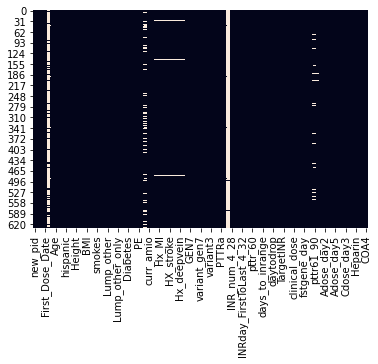

In [28]:
import seaborn as sns

sns.heatmap(df1.isnull(), cbar=False)


In [15]:
#fix races
races= np.array([1, 2, 3, 4])
race_names = ['AA_racec', 'Caucasian_racec', 'Asian_racec', 'Other_racec']
for num in races:
    df1[race_names[num - 1]] = (df1['racec']==(num)).astype('int64', copy=False)

df1 = df1[['new_pid', 'Age','male','Weight','AA_racec', 'Caucasian_racec', 'Asian_racec', 'Other_racec', 'maintain_dose']]
df1.rename(columns={'Weight':'weight'}, inplace = True)
df1.rename(columns={'AA_racec':'AA'}, inplace = True)
df1.rename(columns={'Caucasian_racec':'white'}, inplace = True)
df1.rename(columns={'Asian_racec':'asian'}, inplace = True)
df1.rename(columns={'Other_racec':'other_race'}, inplace = True)
df1['age']=  (df1['Age'].map(lambda num: num // 10)).astype('int64', copy=False)
df1['male']=  (df1['male']).astype('int64', copy=False)
df1 =  df1.drop(['Age'], axis=1)

In [16]:
df7['PREV_INR'] = df7['INR'].shift(1)
df7['PREV_DOSE'] = df7['ADOSE'].shift(1)
df7['DAY_DIFF'] = df7['SDAY'] - df7['SDAY'].shift(1)
df7['INR_DIFF'] = df7['INR'] - df7['INR'].shift(1)

df_c = df7.merge(df1, left_on='new_pid', right_on='new_pid')
print(df_c.shape)
df_c = df_c.drop(df_c[df_c['DAY_DIFF'] < 1].index)
print(df_c.shape)
df_c = df_c.dropna()

(5185, 16)
(4570, 16)


In [17]:
df_c1 = df_c[df_c['SDAY'] < 11]
df_c2 = df_c1[df_c1['SDAY'] > 6]
df_c3 = df_c2[df_c2['DAY_DIFF'] < 6]
df_c4 = df_c3.drop_duplicates(subset='new_pid', keep='first', inplace=False)

df2 = df2.dropna(subset=['clinical_dose4_5'])
df2_clean = df2[['new_pid', 'clinical_dose4_5']]
s1 = df2.new_pid
s2 = df_c4.new_pid
s3 = s1[s1.isin(s2)]

df_c5 = df_c4[df_c4.new_pid.isin(s3)]
df_c5 = df_c5.merge(df2_clean, left_on='new_pid', right_on='new_pid')

print(df_c.shape)
print(df_c1.shape)
print(df_c2.shape)
print(df_c3.shape)
print(df_c4.shape)
print(df_c5.shape)

(4570, 16)
(1244, 16)
(776, 16)
(775, 16)
(613, 16)
(609, 17)


In [18]:
X1 = df_c5[['male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y1 = df_c5[['maintain_dose']].values

X2 = df_c5[['INR', 'SDAY', 'PREV_DOSE', 'male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y2 = df_c5[['maintain_dose']].values

X3 = df_c5[['PREV_INR', 'INR', 'DAY_DIFF', 'PREV_DOSE', 'male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y3 = df_c5[['maintain_dose']].values

X4 = df_c5[['INR', 'PREV_DOSE', 'male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y4 = df_c5[['maintain_dose']].values

X5 = df_c5[['INR_DIFF', 'DAY_DIFF', 'PREV_DOSE', 'male', 'AA', 'white',  'asian', 'other_race', 'age', 'weight']]
y5 = df_c5[['maintain_dose']].values


In [19]:
def train_model(regressor, filename):
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=0, stratify=X1[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred1 = regressor.predict(X_test).reshape(-1,1)
    mse1 = metrics.mean_squared_error(y_test, y_pred1)
    mae1 = metrics.mean_absolute_error(y_test, y_pred1)
    
    X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=0, stratify=X2[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred2 = regressor.predict(X_test).reshape(-1,1)
    mse2 = metrics.mean_squared_error(y_test, y_pred2)
    mae2 = metrics.mean_absolute_error(y_test, y_pred2)
    
    X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=0, stratify=X3[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred3 = regressor.predict(X_test).reshape(-1,1)
    mse3 = metrics.mean_squared_error(y_test, y_pred3)
    mae3 = metrics.mean_absolute_error(y_test, y_pred3)
    
    X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size=0.2, random_state=0, stratify=X4[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred4 = regressor.predict(X_test).reshape(-1,1)
    mse4 = metrics.mean_squared_error(y_test, y_pred4)
    mae4 = metrics.mean_absolute_error(y_test, y_pred4)
    
    X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size=0.2, random_state=0, stratify=X5[['white', 'AA', 'asian', 'other_race']])
    regressor.fit(X_train, y_train)
    y_pred5 = regressor.predict(X_test).reshape(-1,1)
    mse5 = metrics.mean_squared_error(y_test, y_pred5)
    mae5 = metrics.mean_absolute_error(y_test, y_pred5)
    
    y_pred = np.concatenate((y_pred1, y_pred2, y_pred3, y_pred4, y_pred5), 1)
    #np.savetxt(filename, y_pred, delimiter=',', header='feature1, feature2, feature3, feature4, feature5')
    
    mse = [[mse1, mse2, mse3, mse4, mse5]]
    #np.savetxt('mse' + filename, mse, delimiter=',', header='feature1, feature2, feature3, feature4, feature5')
    
    mae = [[mae1, mae2, mae3, mae4, mae5]]
    #np.savetxt('mae' + filename, mae, delimiter=',', header='feature1, feature2, feature3, feature4, feature5')
    
    print(mae)

## Linear Regression

In [20]:
linear = LinearRegression()

train_model(linear, 'linear.csv')

[[1.877268117943685, 1.2520043801330538, 1.2417163175479091, 1.2116642508849034, 1.3853815938276839]]


## Ridge Regression

In [21]:
ridge = Ridge(alpha = .01)

train_model(ridge,'ridge.csv')


[[1.8772891183914664, 1.2519942295497806, 1.2417046894369395, 1.2116568386585724, 1.3853725438464168]]


## Bayesian Ridge Regression

In [22]:
bayesian_ridge = BayesianRidge(tol=1e-6)

train_model(bayesian_ridge, 'bayesian_ridge.csv')


[[1.8978260633535524, 1.2468400448024244, 1.2346670437464786, 1.2083879417086236, 1.3763077021468246]]


## Decision Tree Regression

In [23]:
decision_tree = DecisionTreeRegressor(random_state=0, max_depth = 3)

train_model(decision_tree, 'decision_tree.csv')


[[1.9715580153723054, 1.2804165143131827, 1.2944603948716527, 1.2804165143131827, 1.3651484109081917]]


## Gradient Boosting Regression

In [ ]:
gradient_boosting = GradientBoostingRegressor(random_state=0)

train_model(gradient_boosting, 'gradient_boosting.csv')


[[2.036616763170433, 1.0468551476404124, 1.0350493329337986, 1.0613130576332839, 1.2580173860052386]]


## Multilayer Perceptron Regression

In [ ]:
multilayer_perceptron = MLPRegressor(random_state=0, hidden_layer_sizes=[50,25], max_iter = 10000, activation = 'relu', solver = 'lbfgs')

train_model(multilayer_perceptron, 'multilayer_perceptron.csv')


[[1.8978525990178656, 1.2022340528317859, 1.044677724532586, 1.066567433819926, 1.2015276642254018]]
